# <center>Parameters selection

In [1]:
import os
workdir = "../.."
os.chdir(workdir)

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')

In [3]:
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy as sc
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from numpy.linalg import LinAlgError

from itertools import product

import warnings

In [4]:
from datetime import datetime, timedelta

In [5]:
import json

In [6]:
import tqdm

In [7]:
from processing.common import read_data, data_preprocessing, data_split, calc_sMAE
from settings import data_path, path_to_model
from models.forecast import SalesForecast

## Замечание о данных для подбора параметров

Для подбора параметров будем использовать данные без последних 31 дней. На этих 31 дней мы будем впоследствии валидировать модели, построенные для каждого из магазинов.

## Готовим данные   

In [8]:
store_id = 16

In [9]:
data = read_data(store_id)

In [10]:
data = data_preprocessing(data, store_id)

In [11]:
prediction_horizon = 31
data, _ = data_split(data, prediction_horizon)

## Посмотрим на данные, изучим визуально сезонность

In [12]:
target_col = "target"

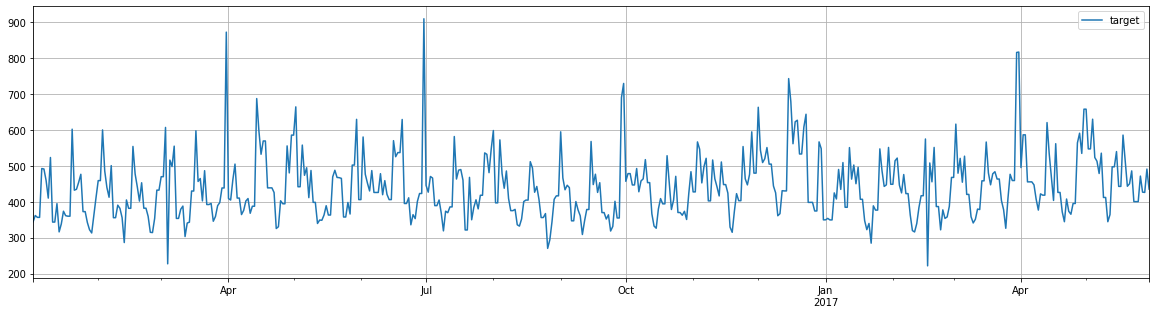

In [13]:
plt.figure(figsize=(20, 5))
data[target_col].plot()
plt.legend()
plt.grid()

## Создадим регрессионные признаки для учёта сезонностей и трендов.

In [14]:
# для недельной сезонности
k_season_series = [1, 2, 3, 4, 5, 6]
hours_in_week = 168 # число часов в неделе
for i in k_season_series:
    data[f'weekly_SIN_{i}'.replace(".", "_")] = np.sin((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)
    data[f'weekly_COS_{i}'.replace(".", "_")] = np.cos((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)

In [15]:
# конец и начало месяца
data['month_end'] = data.index.is_month_end.astype(int)
data['month_start'] = data.index.is_month_start.astype(int)

Добавим в датафрейм день недели и выходной в качестве категориальных переменных

In [16]:
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6]).astype(int)
data.head()

,target,weekly_SIN_1,weekly_COS_1,weekly_SIN_2,weekly_COS_2,weekly_SIN_3,weekly_COS_3,weekly_SIN_4,weekly_COS_4,weekly_SIN_5,weekly_COS_5,weekly_SIN_6,weekly_COS_6,month_end,month_start,weekday,is_weekend
2016-01-02,343.8,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,0.974928,0,0,5,1
2016-01-03,361.6,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,0.900969,0,0,6,1
2016-01-04,356.4,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,0.781831,0,0,0,0
2016-01-05,356.4,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,0.623490,0,0,1,0
2016-01-06,492.3,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,0.433884,0,0,2,0


Добавим признак четной и нечетной недели

In [17]:
data['is_even_week'] = ((data.index.isocalendar().week % 2).astype(int) == 0).astype(int)

In [18]:
data.head(10)

,target,weekly_SIN_1,weekly_COS_1,weekly_SIN_2,weekly_COS_2,weekly_SIN_3,weekly_COS_3,weekly_SIN_4,weekly_COS_4,weekly_SIN_5,weekly_COS_5,weekly_SIN_6,weekly_COS_6,month_end,month_start,weekday,is_weekend,is_even_week
2016-01-02,343.8,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,9.749279e-01,0,0,5,1,0
2016-01-03,361.6,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,9.009689e-01,0,0,6,1,0
2016-01-04,356.4,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,7.818315e-01,0,0,0,0,0
2016-01-05,356.4,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,6.234898e-01,0,0,1,0,0
2016-01-06,492.3,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,4.338837e-01,0,0,2,0,0
2016-01-07,491.0,0.222521,0.974928,0.433884,0.900969,0.623490,0.781831,0.781831,0.623490,0.900969,0.433884,0.974928,2.225209e-01,0,0,3,0,0
2016-01-08,459.1,0.258819,0.965926,0.500000,0.866025,0.707107,0.707107,0.866025,0.500000,0.965926,0.258819,1.000000,6.123234e-17,0,0,4,0,0
2016-01-09,410.0,0.294755,0.955573,0.563320,0.826239,0.781831,0.623490,0.930874,0.365341,0.997204,0.074730,0.974928,-2.225209e-01,0,0,5,1,0
2016-01-10,523.0,0.330279,0.943883,0.623490,0.781831,0.846724,0.532032,0.974928,0.222521,0.993712,-0.111964,0.900969,-4.338837e-01,0,0,6,1,0
2016-01-11,343.3,0.365341,0.930874,0.680173,0.733052,0.900969,0.433884,0.997204,0.074730,0.955573,-0.294755,0.781831,-6.234898e-01,0,0,0,0,1


## Регрессия целевого признака

In [19]:
# Список призднаков для регрессии
feature_list = []
feature_list = data.drop(target_col, axis=1).columns
feature_list

Index(['weekly_SIN_1', 'weekly_COS_1', 'weekly_SIN_2', 'weekly_COS_2',
       'weekly_SIN_3', 'weekly_COS_3', 'weekly_SIN_4', 'weekly_COS_4',
       'weekly_SIN_5', 'weekly_COS_5', 'weekly_SIN_6', 'weekly_COS_6',
       'month_end', 'month_start', 'weekday', 'is_weekend', 'is_even_week'],
      dtype='object')

### use smf.ols

In [20]:
m1 = smf.ols('target ~ ' + ' + '.join(feature_list), data=data)
# fitted = m1.fit()
fitted = m1.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     3.769
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           6.75e-07
Time:                        10:09:49   Log-Likelihood:                -2999.6
No. Observations:                 515   AIC:                             6035.
Df Residuals:                     497   BIC:                             6112.
Df Model:                          17                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      437.5423      7.810     56.026   

Посмотрим на остатки

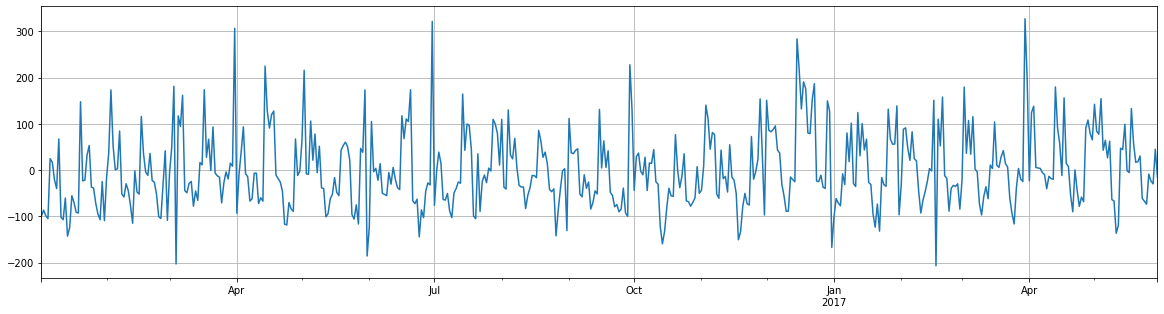

In [21]:
plt.figure(figsize=(20, 5))
fitted.resid.plot();
plt.grid()

В остатках много структуры.

Посмотрим на распределение остатков

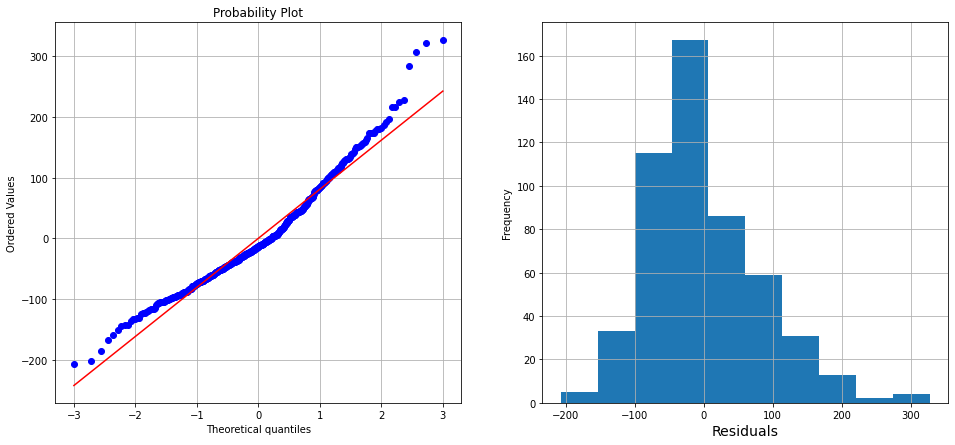

In [22]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.grid()
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.grid()

Распределение близко к гауссову, сделаем некоторые преобразования, чтобы еще более приблизить его к гауссову и к стационарному

## Подбор значения гиперпараметров ARIMA

Посмотрим на **STL-декомпозицию**

Критерий Дики-Фуллера: p=1.082969e-05


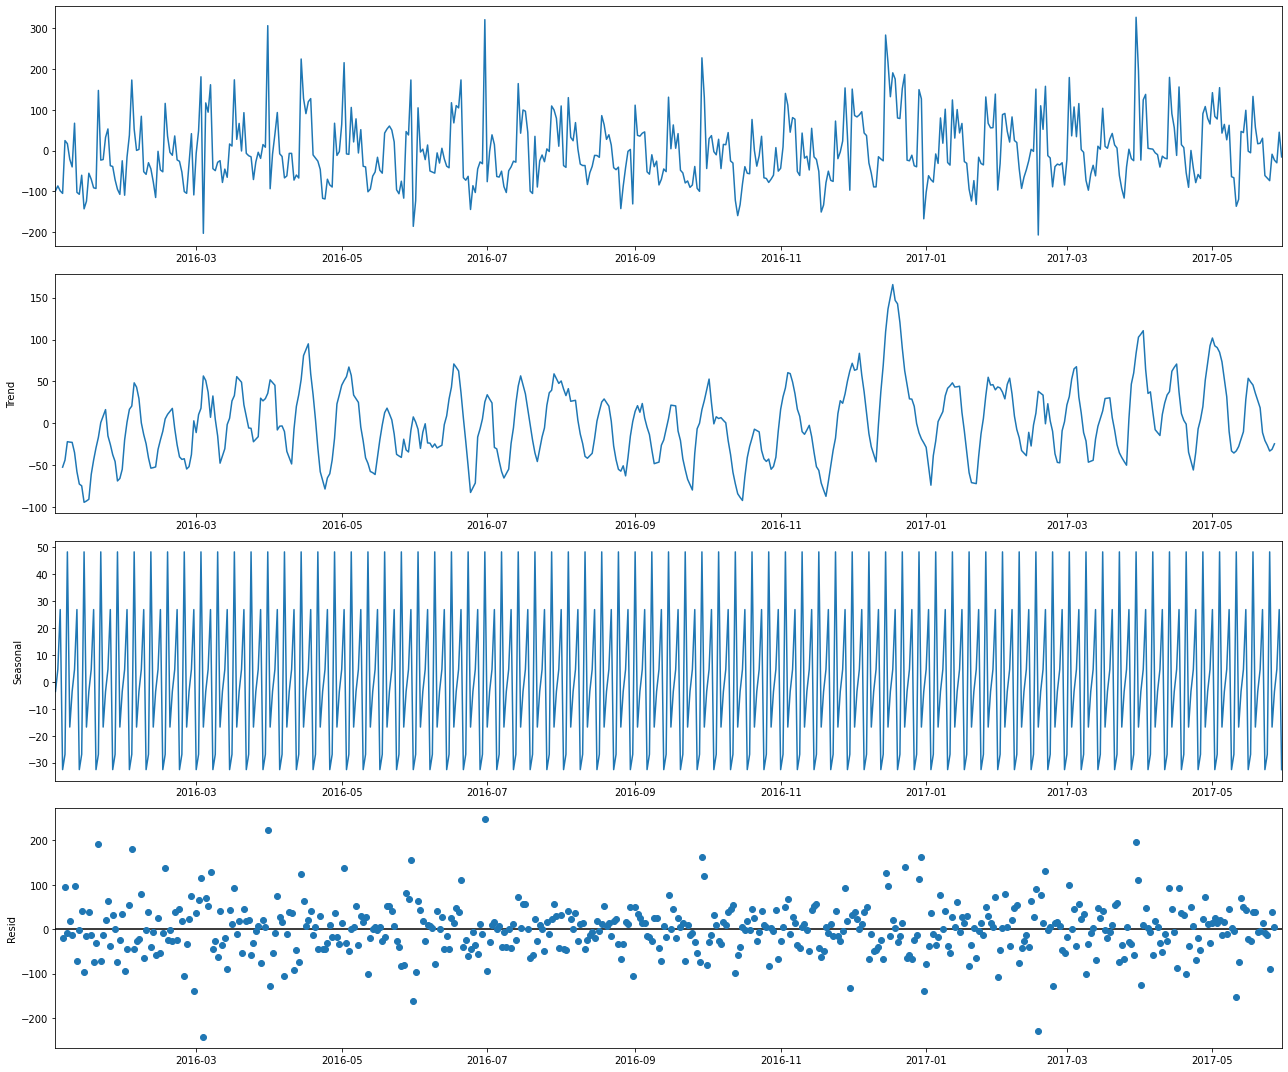

In [23]:
plt.rcParams["figure.figsize"] = (18,15)
sm.tsa.seasonal_decompose(fitted.resid).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(fitted.resid)[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, НО, на мой взгляд, не очень уверенно.    
Напрашивается дифференцирование.   

In [24]:
col = {}
lag = 1

Критерий Дики-Фуллера: p=1.584141e-10


<Figure size 1080x720 with 0 Axes>

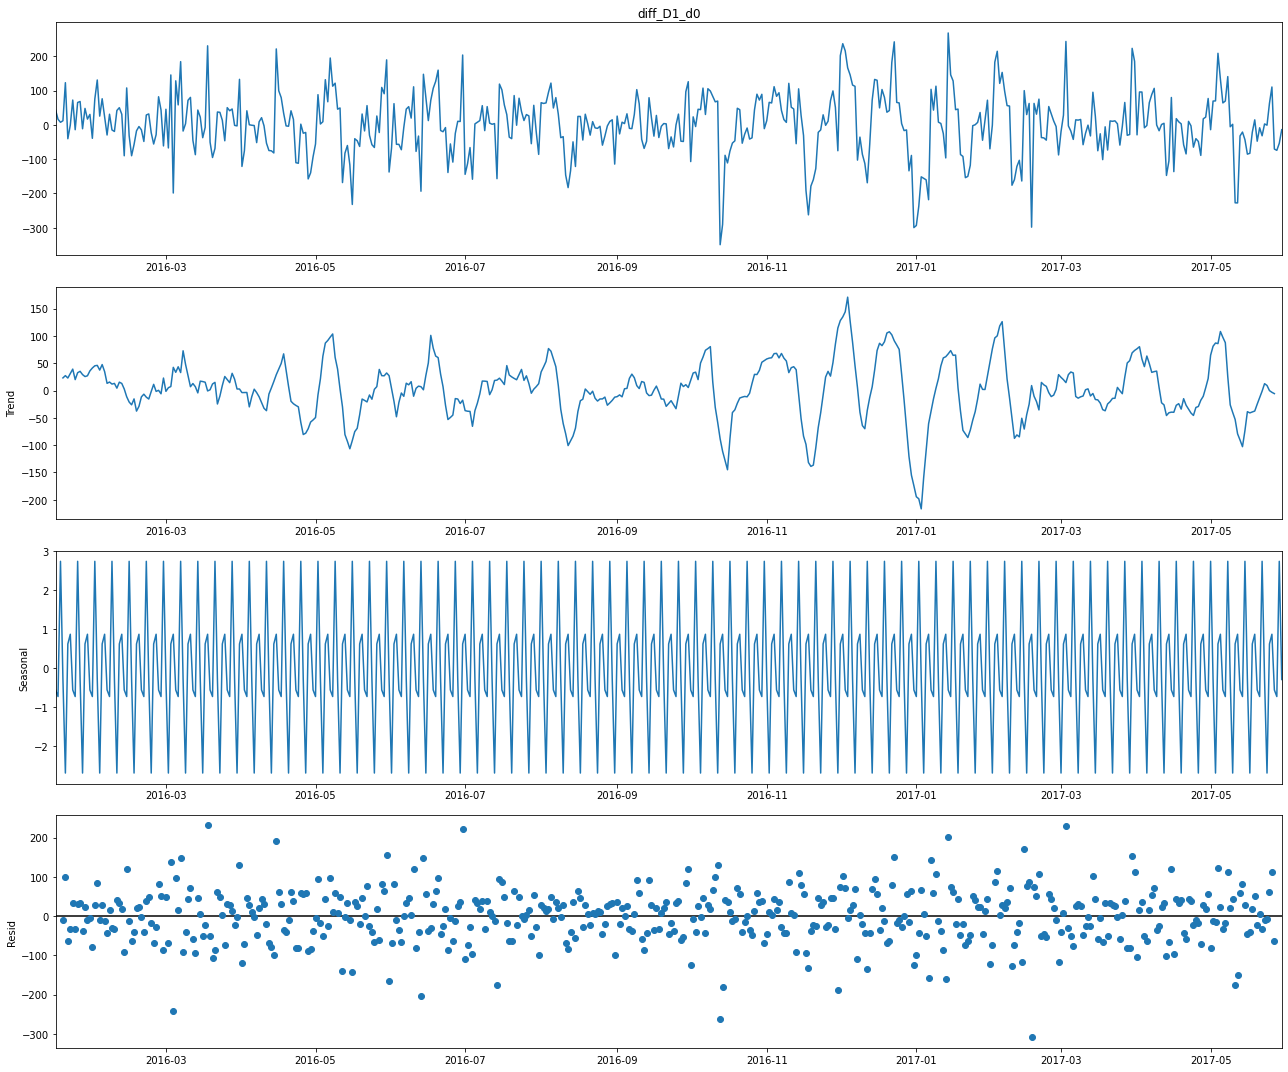

In [25]:
D = 1
S = 14
d = 0
col[(D, d)] = f"diff_D{D}_d{d}"

plt.rcParams["figure.figsize"] = (18,15)
data[col[(D, d)]] = fitted.resid - fitted.resid.shift(S)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data[col[(D, d)]][(D*S+d*lag):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data[col[(D, d)]][(D*S+d*lag):])[1])

Критерий Дики-Фуллера: p=2.316751e-18


<Figure size 1080x720 with 0 Axes>

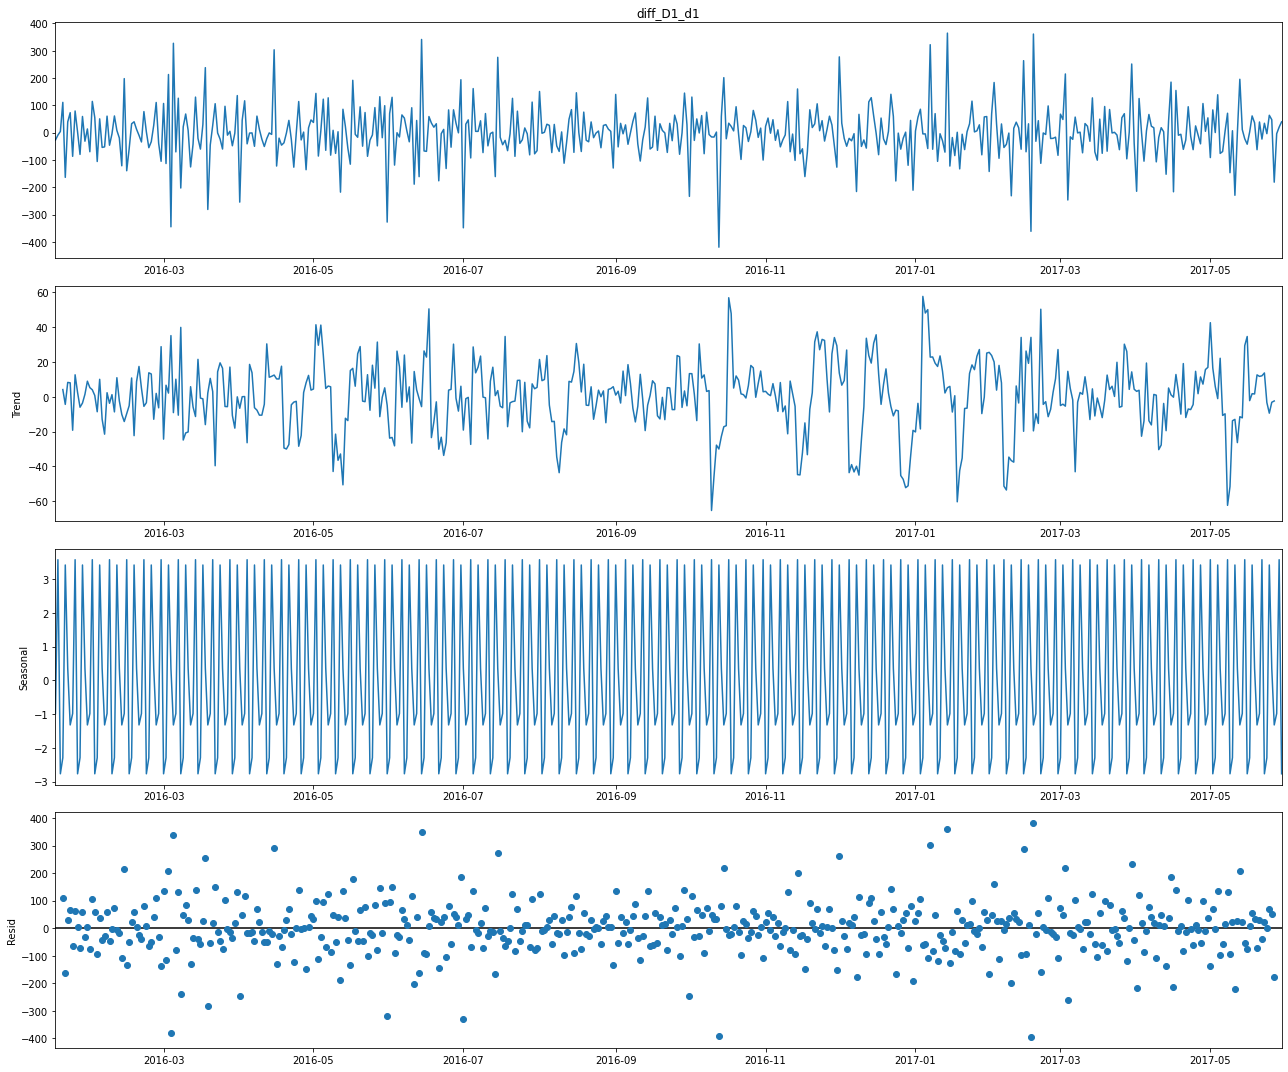

In [26]:
D = 1
S = S
d = 1
col[(D, d)] = f"diff_D{D}_d{d}"

plt.rcParams["figure.figsize"] = (18,15)
data[col[(D, d)]] = data[col[(D, d-1)]] - data[col[(D, d-1)]].shift(lag)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data[col[(D, d)]][(D*S+d*lag):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data[col[(D, d)]][(D*S+d*lag):])[1])

Критерий Дики-Фуллера позволяет считать ряд стационарным.   
Мы провели два дифференцирования - сезонное (сезон = 14 дней) и соседних значений.   

### подбираем p,q,P,Q

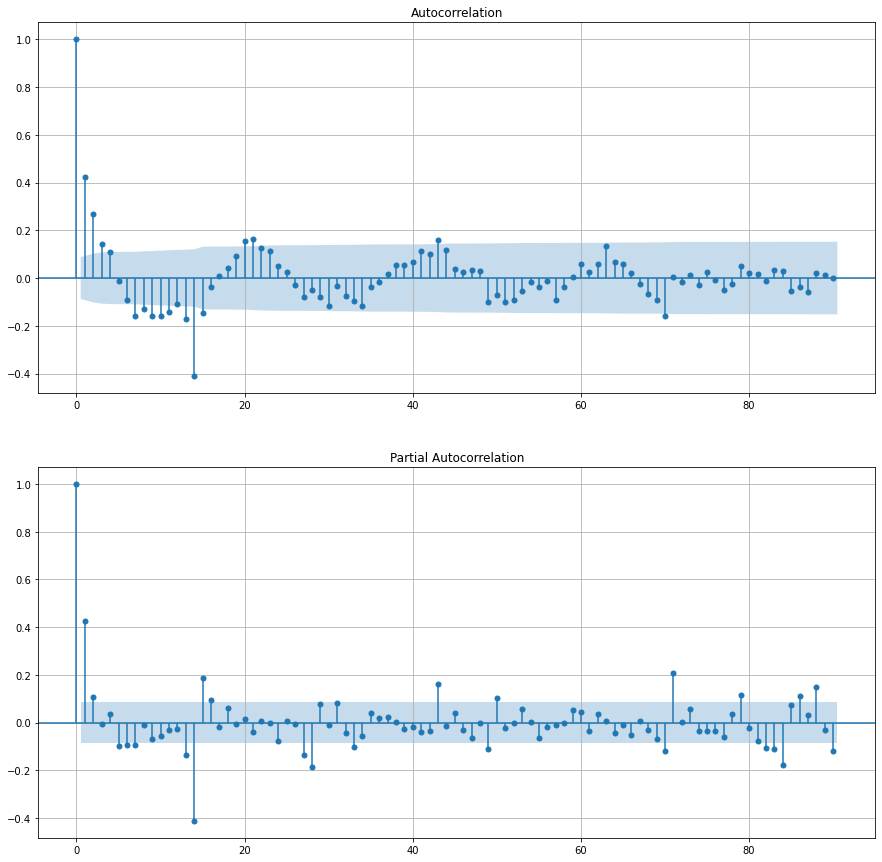

In [27]:
D = 1
d = 0

plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
plt.show()

D:\Users\dsher\PycharmProjects\sales_forecast_model\venv\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


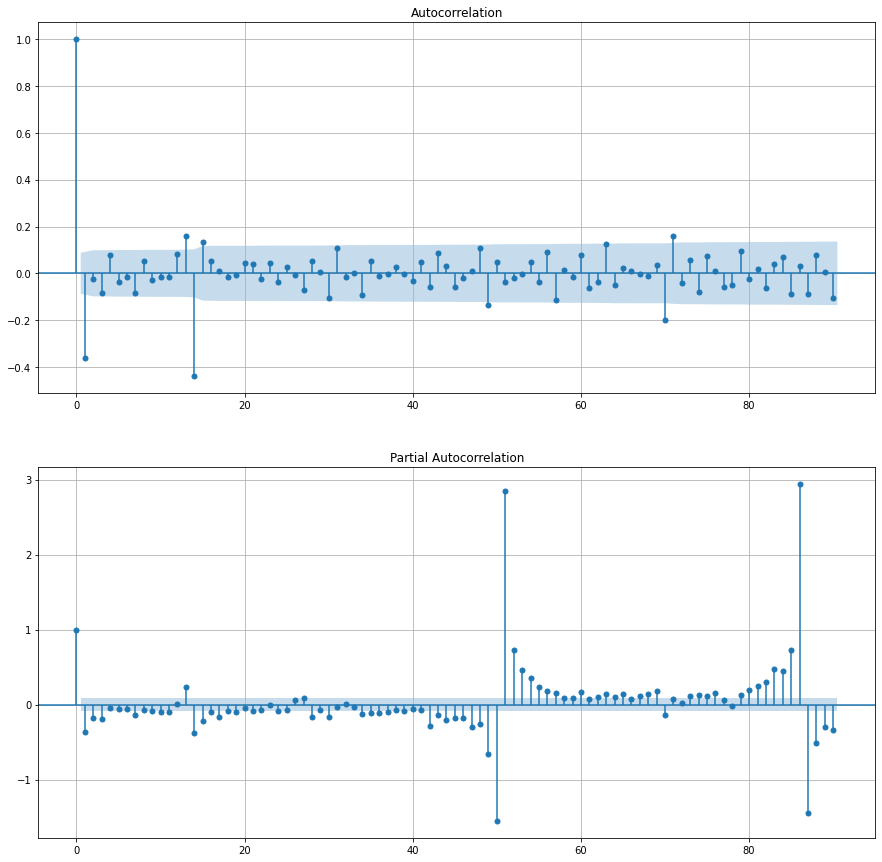

In [28]:
D = 1
d = 1

plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
plt.show()

Выводы: хотя критерий Дики-Фуллера позволяет считать ряд стационарным уже после первого сезонного дифференцирования, сезон = 14 дней, но в данных еще видно много структуры. Второе дифференцирование с лагом = 1 день этот вопрос снимает.

$SARIMA(p,d,q)(P,D,Q)_S$

### Подбор AIC модели
- Выберем оптимальную по AIC модель; 
- построим график исходного ряда и нарисуем поверх предсказания выбранной модели. 

Если модель плохо описывает данные, попробуем увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

In [29]:
D = 1
d = 0
S = S  # 14
lag = lag  # 1

q = 3
p = 2

Q = 1
P = 2

In [30]:
ps = range(p + 1)
qs = range(q + 1)
Ps = range(P + 1)
Qs = range(Q + 1)

In [31]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

#### Функции для сохранения промежуточных результатов
Во время расчетов по подбору оптимальных параметров иногда происходит срубание процесса из-за нехватки ресурсов. При этом все рассчитанные до этого параметры частенько не сохраняются. Чтобы избежать этого, сделаем сохранение результата в каждом цикле. Для этого напишем соответствующую функцию и вставим ее в цикл.

In [32]:
def get_save_params(store_id):
    model_id = f"{store_id}"
    
    # the file names
    model_file_name = f"model_{model_id}.arima"
    hyperparams_file_name = f"hyperparams_{model_id}.json"
    params_df_file_name = f"params_{model_id}.csv"
    
    return model_id, hyperparams_file_name, params_df_file_name, model_file_name

In [33]:
def save_results(results, best_params, store_id, path_to_model, comment,  k_season_series, model_save=False):
    """
    The save of the current results and best params of the model calculation
    """
    # params for saving
    model_id, hyperparams_file_name, params_df_file_name, model_file_name = get_save_params(store_id)
    
    # model
    if model_save:
        best_model.save(os.path.join(path_to_model, model_file_name))
    
    # best params
    best_params_dict = dict()
    best_params_dict['p'] = best_params[0]
    best_params_dict['q'] = best_params[1]
    best_params_dict['d'] = d
    best_params_dict['P'] = best_params[2]
    best_params_dict['Q'] = best_params[3]
    best_params_dict['D'] = D
    best_params_dict['S'] = S
    best_params_dict["k_season_series"] = k_season_series
    best_params_dict['Comment'] = comment

    with open(os.path.join(path_to_model, hyperparams_file_name), "w") as file:
        json.dump(best_params_dict, file)
        
    # common results (all params)
    params_df = pd.DataFrame(list(map(lambda x: x[0], results)), columns=['p', 'q', 'P', 'Q'])
    params_df['aic'] = list(map(lambda x: x[1], results))
    params_df['culc_time_in_minutes'] = list(map(lambda x: x[2], results))
    params_df_sorted = params_df.sort_values(by = 'aic', ascending=True)
    params_df_sorted.to_csv(os.path.join(path_to_model, params_df_file_name))
    
    return model_id, hyperparams_file_name, params_df_file_name, model_file_name

In [34]:
comment = f"store_id = {store_id}"

### Подбор гиперпараметров модели SARIMA

In [35]:
%%time
results = []
best_aic = float("inf")
best_params = None
warnings.filterwarnings('ignore')

for params in tqdm.tqdm(parameters_list, total=len(parameters_list)):
    start_time = datetime.now()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog=data[target_col], 
                                        exog=data[feature_list], 
                                        order=(params[0], d, params[1]), 
                                        seasonal_order=(params[2], D, params[3], S)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters (ValueError):', params)
        continue
    except LinAlgError:
        print('wrong parameters (LinAlgError):', params)
        continue
    except MemoryError as error:
        print(f"MemoryError message: {error}")
        print('wrong parameters (MemoryError):', params)
        continue
    except Exception as exception:
        print(f"Exception message: {exception}")
        print('wrong parameters (Exception):', params)
        continue
        
    end_time = datetime.now()
    model_culc_time_minutes = round((end_time - start_time).seconds / 60, 2)
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_params = params
    results.append([params, model.aic, model_culc_time_minutes])
    
    # save the current results
    model_id, hyperparams_file_name, params_df_file_name, model_file_name = \
        save_results(results, best_params, store_id, path_to_model, comment,  k_season_series)
    
warnings.filterwarnings('default')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [32:35<00:00, 27.17s/it]

Wall time: 32min 35s


## <center>Посмотрим на результат

In [36]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               target   No. Observations:                  515
Model:             SARIMAX(2, 0, 3)x(2, 1, [1], 14)   Log Likelihood               -2812.748
Date:                              Wed, 15 Sep 2021   AIC                           5677.496
Time:                                      10:46:04   BIC                           5787.128
Sample:                                  01-02-2016   HQIC                          5720.512
                                       - 05-30-2017                                         
Covariance Type:                                opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
weekly_SIN_1   -10.4494      8.682     -1.204      0.229     -27.466       6.568
weekly_COS_1    16.6557      8.378      1.988      0.047       0.236      33.076
weekly_SIN_2     9.6585      7.013      1.377      0.168      -4.088      23.405
weekly_COS_2     1.8778      6.132      0.306      0.759     -10.140      13.896
weekly_SIN_3    -1.9699      5.728     -0.344      0.731     -13.196       9.256
weekly_COS_3    12.3628      5.897      2.097      0.036       0.806      23.920
weekly_SIN_4    -3.2053      5.941     -0.540      0.589     -14.849       8.438
weekly_COS_4    -2.2713      5.785     -0.393      0.695     -13.610       9.067
weekly_SIN_5     3.3891      6.901      0.491      0.623     -10.137      16.915
weekly_COS_5   -10.2041      6.565     -1.554      0.120     -23.072       2.663
weekly_SIN_6     4.9115      6.932      0.709      0.479      -8.675      18.498
weekly_COS_6    -5.0916      8.190     -0.622      0.534     -21.143      10.960
month_end      108.2204      9.761     11.087      0.000      89.090     127.351
month_start     28.9327     11.755      2.461      0.014       5.894      51.971
weekday          0.0197   2008.246   9.83e-06      1.000   -3936.070    3936.110
is_weekend       0.0015   2.16e+04   7.08e-08      1.000   -4.24e+04    4.24e+04
is_even_week     2.7695    128.958      0.021      0.983    -249.983     255.522
ar.L1            1.6550      0.078     21.290      0.000       1.503       1.807
ar.L2           -0.8035      0.066    -12.154      0.000      -0.933      -0.674
ma.L1           -1.3132      0.089    -14.753      0.000      -1.488      -1.139
ma.L2            0.5204      0.070      7.455      0.000       0.384       0.657
ma.L3            0.0100      0.064      0.156      0.876      -0.115       0.135
ar.S.L14         0.2570      0.052      4.939      0.000       0.155       0.359
ar.S.L28         0.1485      0.050      2.981      0.003       0.051       0.246
ma.S.L14        -0.9985      1.010     -0.988      0.323      -2.978       0.981
sigma2        4063.2629   4018.171      1.011      0.312   -3812.208    1.19e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               116.68
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.07
Prob(H) (two-sided):                  0.98   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model_id, hyperparams_file_name, params_df_file_name, model_file_name = get_save_params(store_id)

print("model_id:", model_id)
print("hyperparams_file_name:", hyperparams_file_name)
print("params_df_file_name:", params_df_file_name)
print("model_file_name:", model_file_name)

model_id: 16
hyperparams_file_name: hyperparams_16.json
params_df_file_name: params_16.csv
model_file_name: model_16.arima


### load the best params

In [38]:
# load test
with open(os.path.join(path_to_model, hyperparams_file_name)) as file:
    best_params_dict = json.load(file)
best_params_dict

{'p': 2,
 'q': 3,
 'd': 0,
 'P': 2,
 'Q': 1,
 'D': 1,
 'S': 14,
 'k_season_series': [1, 2, 3, 4, 5, 6],
 'Comment': 'store_id = 16'}

In [39]:
params = pd.read_csv(os.path.join(path_to_model, params_df_file_name), index_col=0)
params.head()

,p,q,P,Q,aic,culc_time_in_minutes
71,2,3,2,1,5677.495946,0.62
69,2,3,1,1,5685.034483,0.40
53,2,0,2,1,5687.018813,0.62
59,2,1,2,1,5688.385433,0.83
41,1,2,2,1,5688.472801,1.33


## sMAE calculation

In [40]:
def calc_id_sMAE(store_id, prediction_horizon=31):
    data = read_data(store_id)
    data = data_preprocessing(data, store_id)
    train, valid = data_split(data, prediction_horizon)
    
    hyperparams_file_name = f"hyperparams_{store_id}.json"    
    with open(os.path.join(path_to_model, hyperparams_file_name)) as file:
        params = json.load(file)
    
    warnings.filterwarnings('ignore')
    sales_forecast = SalesForecast(train, params=params)
    sales_forecast.fit()
    warnings.filterwarnings('default')
    
    predict = sales_forecast.predict(prediction_horizon)
    sMAE = calc_sMAE(predict, valid, train)
    return sMAE

In [41]:
%%time
sMAE = calc_id_sMAE(store_id)

Wall time: 46.4 s


In [42]:
print(f"id: {store_id}, sMAE: {sMAE: 0.3f}")

id: 16, sMAE:  0.185
